Comparison of all Densenet models architecture 
(Densenet-121 , Densenet-169 and Densenet-201 )

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Import necessary packages
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

In [5]:
#Load dataset
# set cell_images folder path for dataset
root ="/content/gdrive/My Drive/Malaria_dataset/cell_images"

# read dataset
base_dir = os.path.join('/content/gdrive/My Drive/Malaria_dataset/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13794)

In [6]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
1,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
2,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
3,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
4,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria


In [7]:
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17370,) (1931,) (8272,)
Train: Counter({'healthy': 8766, 'malaria': 8604}) 
Val: Counter({'malaria': 979, 'healthy': 952}) 
Test: Counter({'malaria': 4196, 'healthy': 4076})


In [8]:
#resize images and split dataset into training,testing and validation data 
IMG_DIMS = (125,125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.bilateralFilter(img, 15, 75, 75)
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:ThreadPoolExecutor-0_0: working on img num: 0

ThreadPoolExecutor-0_18: working on img num: 5000
ThreadPoolExecutor-0_5: working on img num: 10000
ThreadPoolExecutor-0_9: working on img num: 15000
ThreadPoolExecutor-0_8: working on img num: 17369

Loading Validation Images:
ThreadPoolExecutor-0_5: working on img num: 0
ThreadPoolExecutor-0_11: working on img num: 1930

Loading Test Images:
ThreadPoolExecutor-0_9: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 5000
ThreadPoolExecutor-0_15: working on img num: 8271


((17370, 125, 125, 3), (1931, 125, 125, 3), (8272, 125, 125, 3))

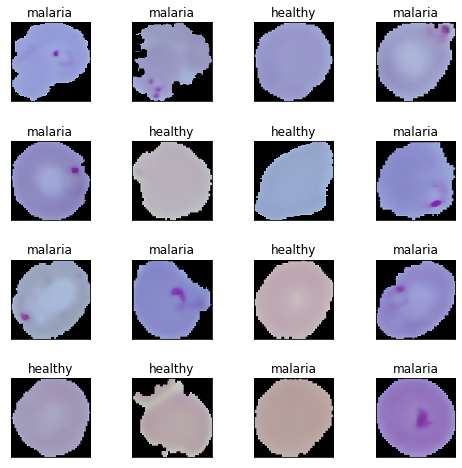

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [12]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

# change version of tensorflow
%tensorflow_version 2.x

#scale data
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
print(train_labels[:6], train_labels_enc[:6])

['healthy' 'healthy' 'healthy' 'healthy' 'healthy' 'healthy'] [0 0 0 0 0 0]


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy']


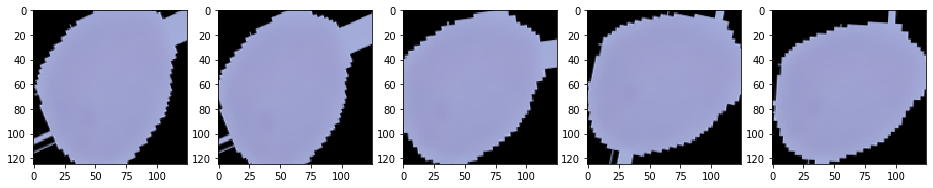

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

#Applying Data augmentation to images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

**Densenet-121 Model**

In [0]:
#Load pretrained model without weights
densenet = tf.keras.applications.densenet.DenseNet121(include_top=False, weights=None, input_shape=INPUT_SHAPE)

for layer in densenet.layers:
    layer.trainable = True

base_densenet =densenet
base_out = base_densenet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(1664, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(1664, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_densenet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


In [0]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

In [0]:
import datetime 
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

In [0]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Densenet-121 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Densenet121_architect.h5')

**Densenet-169 Model**

In [29]:
#Load pretrained model without weights
densenet = tf.keras.applications.densenet.DenseNet169(include_top=False, weights=None, input_shape=INPUT_SHAPE)

for layer in densenet.layers:
    layer.trainable = True

base_densenet =densenet
base_out = base_densenet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(1664, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(1664, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_densenet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 131, 131, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 63, 63, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 63, 63, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [30]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 601
Total trainable layers: 601


In [31]:
import datetime 
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/35
271/271 [==============================] - 85s 315ms/step - loss: 0.6733 - accuracy: 0.6344 - val_loss: 0.7156 - val_accuracy: 0.5109
Epoch 2/35
271/271 [==============================] - 59s 219ms/step - loss: 0.5818 - accuracy: 0.6991 - val_loss: 0.8039 - val_accuracy: 0.6000
Epoch 3/35
271/271 [==============================] - 59s 218ms/step - loss: 0.5519 - accuracy: 0.7252 - val_loss: 0.5413 - val_accuracy: 0.7203
Epoch 4/35
271/271 [==============================] - 59s 218ms/step - loss: 0.5172 - accuracy: 0.7475 - val_loss: 0.6657 - val_accuracy: 0.6479
Epoch 5/35
271/271 [==============================] - 59s 218ms/step - loss: 0.5008 - accuracy: 0.7533 - val_loss: 0.4963 - val_accuracy: 0.7646
Epoch 6/35
271/271 [==============================] - 59s 217ms/step - loss: 0.4732 - accuracy: 0.7744 - val_loss: 0.4494 - val_accuracy: 0.7854
Epoch 7/35
271/271 [=================

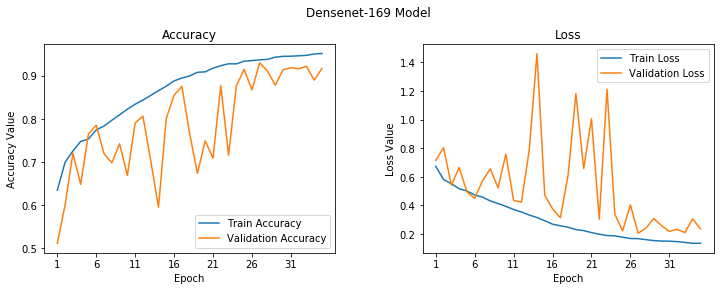

In [32]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Densenet-169 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Densenet169_architect.h5')

**Densenet-201 model**

In [34]:
#Load pretrained model without weights
densenet = tf.keras.applications.densenet.DenseNet201(include_top=False, weights=None, input_shape=INPUT_SHAPE)

for layer in densenet.layers:
    layer.trainable = True

base_densenet =densenet
base_out = base_densenet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(1664, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(1664, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_densenet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 131, 131, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 63, 63, 64)   9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 63, 63, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [35]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 713
Total trainable layers: 713


In [39]:
import datetime 
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1155 - accuracy: 0.9600 - val_loss: 0.2291 - val_accuracy: 0.9380
Epoch 2/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1090 - accuracy: 0.9641 - val_loss: 0.1924 - val_accuracy: 0.9474
Epoch 3/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1049 - accuracy: 0.9637 - val_loss: 0.1901 - val_accuracy: 0.9510
Epoch 4/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1059 - accuracy: 0.9627 - val_loss: 0.1879 - val_accuracy: 0.9490
Epoch 5/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1052 - accuracy: 0.9638 - val_loss: 0.2480 - val_accuracy: 0.9375
Epoch 6/35
271/271 [==============================] - 69s 254ms/step - loss: 0.1050 - accuracy: 0.9648 - val_loss: 0.3184 - val_accuracy: 0.9240
Epoch 7/35
271/271 [=================

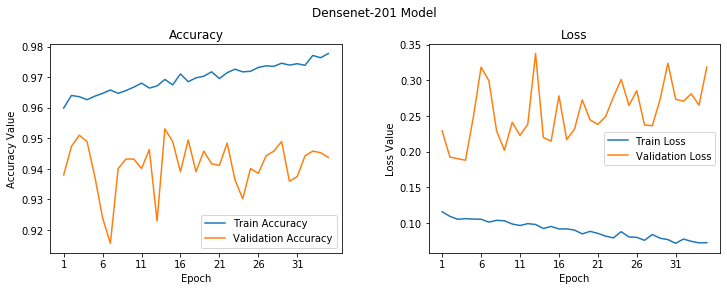

In [40]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Densenet-201 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Densenet201_architect.h5')

In [42]:
#scale test data
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8272, 125, 125, 3), (8272,))

In [0]:
# Load Saved Deep Learning Models
densenet121 = tf.keras.models.load_model('/content/Densenet121_architect.h5')
densenet169 = tf.keras.models.load_model('/content/Densenet169_architect.h5')
densenet201 = tf.keras.models.load_model('/content/Densenet201_architect.h5')

# Make Predictions on Test Data
densenet121_preds = densenet121.predict(test_imgs_scaled, batch_size=256)
densenet169_preds = densenet169.predict(test_imgs_scaled, batch_size=256)
densenet201_preds = densenet201.predict(test_imgs_scaled, batch_size=256)

densenet121_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in densenet121_preds.ravel()])
densenet169_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in densenet169_preds.ravel()])
densenet201_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in densenet201_preds.ravel()])

In [0]:
#upload model evaluation file named as model_evaluation_utils
from google.colab import files 
uploaded = files.upload()

In [45]:
import model_evaluation_utils as meu
import pandas as pd

densenet121_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=densenet121_pred_labels)
densenet169_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=densenet169_pred_labels)
densenet201_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=densenet201_pred_labels)

pd.DataFrame([densenet121_metrics , densenet169_metrics , densenet201_metrics], 
             index=['Densenet-121','Densenet-169', 'Densenet-201'])

,Accuracy,Precision,Recall,Sensitivity,specificity,F1 Score
Densenet-121,93.9192,93.9675,93.9192,92.4448,95.4467,93.9191
Densenet-169,92.2268,92.2574,92.2268,93.3569,91.1894,92.2236
Densenet-201,94.8622,94.9807,94.8622,92.6021,97.2912,94.8608
